Utilisation d'un GRU pour améliorer le modele simple

In [2]:
import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer


from RktnChallenge.preprocessing.tokenizeString import tokenizeString
from RktnChallenge.preprocessing.filterStopWords import filterStopWords
from RktnChallenge.preprocessing.mergeFeatures import mergeFeatures
from RktnChallenge.preprocessing.mostOccur import mostOccur
from RktnChallenge.preprocessing.Dropper import Dropper
from RktnChallenge.preprocessing.TokenListToString import TokenListToString

from RktnChallenge.preprocessing.filterChar import filterChar
from RktnChallenge.preprocessing.lemmatize import lemmatize
from RktnChallenge.preprocessing.regularExprSub import regularExprSub

2023-09-07 16:40:50.640737: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-07 16:40:50.673075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 16:40:51.235713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-07 16:40:53.409027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
RktnModel = ModelTrainer("data_tr.csv")

Removing StopWords

In [3]:



RktnModel = ModelTrainer("data_tr_lemm.csv")


Vectorization des données

In [4]:
_X = RktnModel.data["merged_desi_desc"]

RktnModel.create_vectorizer(name="tokenizer", X = _X, ngram_range=(1,3))

X_data = RktnModel.vectorizer_transform(_X)     


y = RktnModel.encodeLabel("prdtypecode")
label_size = RktnModel.getLabelSize()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)


Definition d'un modele

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, GRU, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW



embedding_dim = 100  # Dimension de l'incorporation des mots


# Entrée du modèle
input_layer = Input(shape=(RktnModel.max_seq_length,))
embedding_layer = Embedding(input_dim=RktnModel.vocab_size, output_dim=embedding_dim)(input_layer)

# Couche GRU

gru_layer = GRU(units=64, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

# Couches denses
dense_layer = Dense(units=128, activation='relu')(gru_layer)
dropout_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(units=label_size, activation='softmax')(dropout_layer)

# Création du modèle
model = Model(inputs=input_layer, outputs=output_layer)
 
optimizer = AdamW(weight_decay=0.01, learning_rate=0.001) 


model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 922)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 922, 100)          14216400  
                                                                 
 gru_2 (GRU)                 (None, 64)                31872     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 27)                3483      
                                                                 
Total params: 14260075 (54.40 MB)
Trainable params: 1426007

In [10]:
history = model.fit(X_train, y_train, epochs= 10, batch_size=100, validation_split=0.2)

Epoch 1/10
544/544 [==============================] - 351s 642ms/step - loss: 3.1120 - accuracy: 0.1184 - val_loss: 3.0914 - val_accuracy: 0.1209
Epoch 2/10
150/544 [=======>......................] - ETA: 3:54 - loss: 3.0994 - accuracy: 0.1188

: 

: 

531/531 [==============================] - 2s 3ms/step
weighted F1 score: 0.8258706457604833


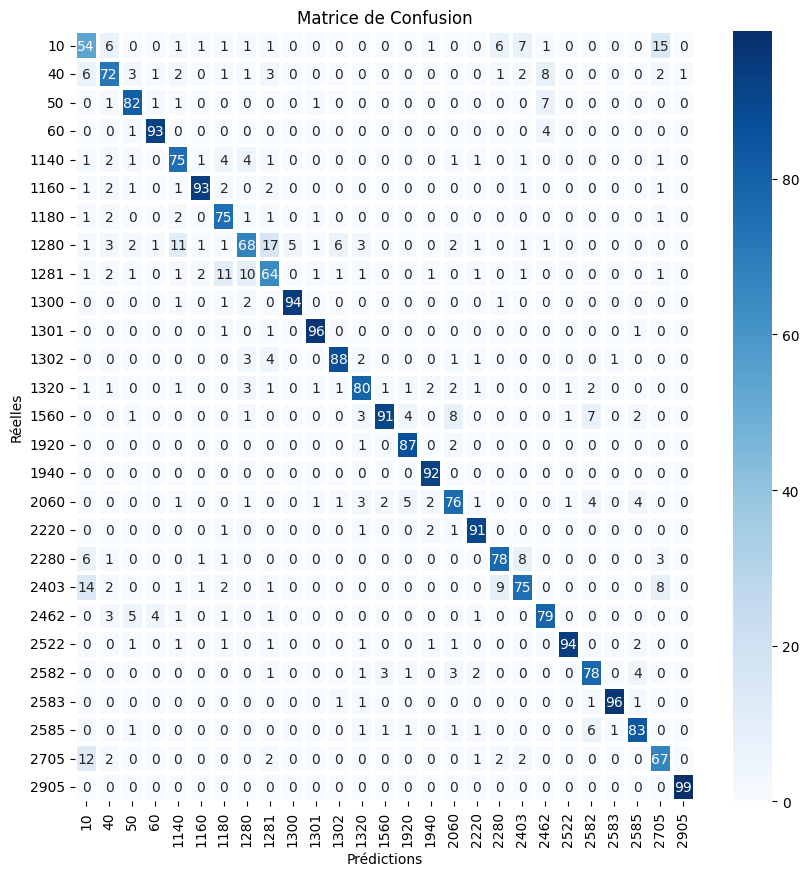

/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:


y_pred_test = model.predict(X_test)
y_pred_id = y_pred_test.argmax(axis=-1)

RktnModel.evaluateTestResults(y_test,y_pred_id)


model.save("model_simple.h5")